In [120]:
'''Generate Samples'''
import numpy as np
import pandas as pd
import random

# Define parameters for the 1D Ising Model
num_nodes = 3
num_edges = num_nodes - 1

# Define number of samples
num_samples = 100

# Function to solve the spin configuration
def spin_config_solver(edge_weights): # input: the "edge_weights" list
    spins = [random.choice([-1, 1])] # choose the first spin randomly from -1 and 1
    for i in range(num_edges):
        if edge_weights[i] >= 0:
            spins.append(spins[i]) # if the i-th edge-weight >= 0, then the next spin is set equal to the current spin
        else:
            spins.append(-spins[i]) # if the i-th edge-weith is less than 0, then the next spin is set equal to the opposite of the current spin
    return spins

# Function to calculate the Hamiltonian
def hamiltonian_solver(edge_weights, spins): # input: "edge_weights" list, "spins" list
    hamiltonian = 0
    for i in range(num_edges):
        hamiltonian += -edge_weights[i] * spins[i] * spins[i + 1]
    return hamiltonian

# Generate samples
samples = []
for _ in range(num_samples):
    # Randomly assign weights to the edges (between -1 and 1)
    edge_weights = np.random.uniform(-1, 1, num_edges)
    # Solve for spin configuration
    spins = spin_config_solver(edge_weights)
    # Calculate the Hamiltonian
    hamiltonian = hamiltonian_solver(edge_weights, spins)
    # Store the result
    samples.append({
        "edge_weights": edge_weights,
        "spins": spins,
        "hamiltonian": hamiltonian
    })

# Convert samples to a pandas DataFrame
samples_df = pd.DataFrame([{**{
    f"edge_{i}-{i+1}": weights[i] for i in range(len(weights))
}, **{
    f"spin_{i}": spins[i] for i in range(len(spins))
}, "hamiltonian": hamiltonian} for sample in samples for weights, spins, hamiltonian in [(sample["edge_weights"], sample["spins"], sample["hamiltonian"])]])

samples_df.head()


,edge_0-1,edge_1-2,spin_0,spin_1,spin_2,hamiltonian
0,-0.060815,0.495986,-1,1,1,-0.556801
1,-0.389816,-0.133052,1,-1,1,-0.522869
2,-0.415106,-0.798569,1,-1,1,-1.213675
3,-0.730177,0.444354,1,-1,-1,-1.174531
4,0.313904,-0.075507,1,1,-1,-0.389411


In [2]:
# def calculate_opposite_absolute_sum(weights):
#     return -np.sum(np.abs(weights))

# samples_df["opposite_abs_sum_of_edge_weights"] = samples_df.apply(
#     lambda row: calculate_opposite_absolute_sum([row[f"edge_{i}-{i+1}"] for i in range(num_edges)]), axis=1
# )

# samples_df.head()

,edge_0-1,edge_1-2,edge_2-3,edge_3-4,edge_4-5,edge_5-6,edge_6-7,edge_7-8,edge_8-9,spin_0,...,spin_2,spin_3,spin_4,spin_5,spin_6,spin_7,spin_8,spin_9,hamiltonian,opposite_abs_sum_of_edge_weights
0,-0.850120,-0.101676,0.411878,-0.056664,0.325249,0.134893,-0.065505,0.866739,-0.424992,-1,...,-1,-1,1,1,1,-1,-1,1,-3.237717,-3.237717
1,-0.316317,0.767877,-0.080166,0.756458,0.524483,-0.874196,-0.182088,0.837825,0.742174,1,...,-1,1,1,1,-1,1,1,1,-5.081585,-5.081585
2,0.893560,-0.819725,0.305784,-0.759857,-0.287776,-0.260347,0.440156,-0.531989,-0.343900,1,...,-1,-1,1,-1,1,1,-1,1,-4.643093,-4.643093
3,0.331697,-0.534931,-0.879002,0.464513,-0.074494,-0.204365,0.559636,0.680599,0.665327,1,...,-1,1,1,-1,1,1,1,1,-4.394562,-4.394562
4,0.881537,0.183870,0.542704,0.090731,-0.547609,-0.283831,0.294172,0.190148,-0.840338,-1,...,-1,-1,-1,1,-1,-1,-1,1,-3.854941,-3.854941


In [121]:
# Save the DataFrame to a CSV file
samples_df.to_csv("1d_straight_ising_model_samples.csv", index=False)

Estimate the Hamiltonian using edge weights, by linear regression

In [122]:
data = pd.read_csv("1d_straight_ising_model_samples.csv")
data.head()

,edge_0-1,edge_1-2,spin_0,spin_1,spin_2,hamiltonian
0,-0.060815,0.495986,-1,1,1,-0.556801
1,-0.389816,-0.133052,1,-1,1,-0.522869
2,-0.415106,-0.798569,1,-1,1,-1.213675
3,-0.730177,0.444354,1,-1,-1,-1.174531
4,0.313904,-0.075507,1,1,-1,-0.389411


In [125]:
X = data.iloc[:,0:num_edges]

# print(type(X))
# print(X.iloc[0:5])
X.head()

,edge_0-1,edge_1-2
0,-0.060815,0.495986
1,-0.389816,-0.133052
2,-0.415106,-0.798569
3,-0.730177,0.444354
4,0.313904,-0.075507


In [126]:
Y = data['hamiltonian']
print(type(Y))
print(Y.shape)
Y.head()

<class 'pandas.core.series.Series'>
(100,)


0   -0.556801
1   -0.522869
2   -1.213675
3   -1.174531
4   -0.389411
Name: hamiltonian, dtype: float64

In [127]:
def featurization(X):
    X_feat = X.copy()
    X_feat = abs(X_feat)
    X_feat.insert(0, 'x0', np.ones(len(X_feat.index))) # X_feat.index represents the row labels, len(X_feat.index) gives the number of rows in the DataFrame
    return X_feat

X_feat = featurization(X)

print(X_feat.index)

print(X_feat)
print(X_feat.shape)
X_feat.head()

RangeIndex(start=0, stop=100, step=1)
     x0  edge_0-1  edge_1-2
0   1.0  0.060815  0.495986
1   1.0  0.389816  0.133052
2   1.0  0.415106  0.798569
3   1.0  0.730177  0.444354
4   1.0  0.313904  0.075507
..  ...       ...       ...
95  1.0  0.459047  0.219259
96  1.0  0.377538  0.937434
97  1.0  0.424673  0.234634
98  1.0  0.016073  0.344422
99  1.0  0.983212  0.435956

[100 rows x 3 columns]
(100, 3)


,x0,edge_0-1,edge_1-2
0,1.0,0.060815,0.495986
1,1.0,0.389816,0.133052
2,1.0,0.415106,0.798569
3,1.0,0.730177,0.444354
4,1.0,0.313904,0.075507


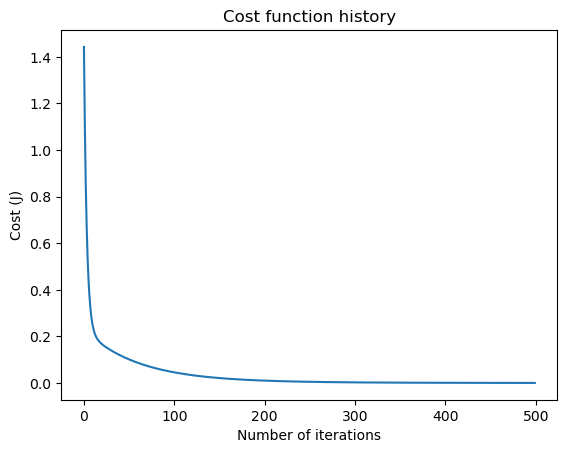

In [130]:
# Define Cost Function
def cost(X_feat, y, theta):
    ''' Function to calculate cost function assuming a hypothesis of form h = theta.T*X
  Inputs:
  X_feat = feature matrix
  y = ground true of training data
  theta = array of parameters for hypothesis

  Returns:
  J = cost function
  '''
    m = len(y)
    h = np.dot(theta, X_feat.T) # hypothesis
    J = (1/(2*m)) * np.sum( (h - y)**2 )
    return J

def jacobian(X_feat, y, theta):
    ''' Function to calculate jacobian assuming a hypothesis of form h = theta.T*X
    Inputs:
    X_feat = feature matrix
    y = ground true of training data
    theta = array of parameters for hypothesis

    Outputs:
    Jac = Jacobian of the hypothesis h = theta.T*X
    '''
    m = len(y)
    h = np.dot(theta, X_feat.T) # hypothesis
    Jac = (1/m) * np.dot((h-y), X_feat)
    return Jac


# Define Gradient Descent Algorithm
def gradient_descent(X_feat, y, theta, lr, num_iters):
    '''Gradient descent algorithm
    Inputs:
    X_feat = features
    y = training data ground true
    theta = parameters of the hypothesis
    lr = learning rate
    num_iters = number of iterations

    Output:
    theta = final parameters
    J_hist = array of cost as a function of iterations
    '''

    J_hist = np.zeros(num_iters)

    for i in range(num_iters):
        # updata theta (hypothesis parameters)
        Jac = jacobian(X_feat, y, theta)
        theta -= lr * Jac

        # record history of cost
        J_hist[i] = cost(X_feat, y, theta)
        
    return theta, J_hist

'''Perform gradient descent'''
import random
# initialize theta
theta = np.random.uniform(-2, 2, X_feat.shape[1])

lr=0.1
num_iters=500
# run gradient descent
theta, J_hist = gradient_descent(X_feat, Y, theta, lr, num_iters)


import matplotlib.pyplot as plt
# Plot cost function history
plt.plot(range(num_iters), J_hist)
plt.xlabel("Number of iterations")
plt.ylabel("Cost (J)")
plt.title("Cost function history")
plt.show()

In [131]:
J_hist[-1]

0.0002613089066169301

In [97]:
X_feat.shape[1]

10

In [104]:
import random

theta = np.random.uniform(-2, 2, X_feat.shape[1])
print("theta shape:", theta.shape)

print("X_feat.T.shape:", X_feat.T.shape)

h = np.dot(theta, X_feat.T)
#h = np.dot(X_feat, theta)
print("h.shape:", h.shape)

Jac = jacobian(X_feat, Y, theta)
print("Jac.shape", Jac.shape)

theta shape: (10,)
X_feat.T.shape: (10, 100)
h.shape: (100,)
Jac.shape (10,)
